In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

In [2]:
# import dataset
supermarket_data = pd.read_csv('supermarket_sales - Sheet1.csv', index_col=0)

In [3]:
# view dataset
supermarket_data.head()

,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
Invoice ID,,,,,,,,,,,,,,,,
750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [4]:
# basic info
print('There are '
    f'{supermarket_data.shape[0]} rows and '
    f'{supermarket_data.shape[1]} columns '
    'in the supermarket_sales dataset.'
)
print('The datatypes in the supermarket_sales dataset are: ')
display(supermarket_data.dtypes)

There are 1000 rows and 16 columns in the supermarket_sales dataset.
The datatypes in the supermarket_sales dataset are: 


Branch                      object
City                        object
Customer type               object
Gender                      object
Product line                object
Unit price                 float64
Quantity                     int64
Tax 5%                     float64
Total                      float64
Date                        object
Time                        object
Payment                     object
cogs                       float64
gross margin percentage    float64
gross income               float64
Rating                     float64
dtype: object

Some features are inaccurate or unnecessary.
- Branch - Unnecessary (duplicate of City)
- Tax - Unnecessary (percentage of total)
- Total - Unnecessary (includes tax)
- cogs - inaccurate (total unit price, not COGS)
- gross margin percentage - inaccurate (same as tax column, as percentage of total)
- gross income - inaccurate (duplicate of tax)

Some features can be modified or engineered.
- Customer type - Boolean encoding to "member"
- Gender - Boolean encoding to "male"
- Date of purchase and Purchase time - Datetime encoding to "saledate"
- Unit price and Quantity - engineer "sale_gross"

In [5]:
# choose features, datetime conversion, set datetime to index
supermarket_data = pd.read_csv(
    'supermarket_sales - Sheet1.csv',
    usecols=[
        'City',
        'Customer type',
        'Gender',
        'Product line',
        'Unit price',
        'Quantity',
        'Payment',
        'Rating',
        'Date',
        'Time'
    ],
    parse_dates={'saledate': ['Date', 'Time']},
    index_col='saledate'
).sort_index()

# modify member and gender features to boolean
supermarket_data['member'] = supermarket_data['Customer type'].map(
    {'Normal': 0, 'Member': 1}
)
supermarket_data['male'] = supermarket_data['Gender'].map(
    {'Female': 0, 'Male': 1}
)
supermarket_data = supermarket_data.drop(
    columns=[
        'Customer type',
        'Gender'
    ]
)

# engineer gross sales feature
supermarket_data['sale_gross'] = (
    supermarket_data['Unit price'] * supermarket_data['Quantity']
)

# rename columns
supermarket_data = supermarket_data.rename(
    columns={
        'Invoice ID': 'invoice',
        'City': 'branch',
        'Product line': 'category',
        'Unit price': 'unit_price',
        'Quantity': 'quantity',
        'Payment': 'payment_type',
        'Rating': 'rating'
    }
)

In [6]:
# customized dataset
supermarket_data.head()

,branch,category,unit_price,quantity,payment_type,rating,member,male,sale_gross
saledate,,,,,,,,,
2019-01-01 10:39:00,Yangon,Sports and travel,72.61,6,Credit card,6.9,0,1,435.66
2019-01-01 11:36:00,Mandalay,Food and beverages,84.63,10,Credit card,9.0,1,0,846.30
2019-01-01 11:40:00,Naypyitaw,Sports and travel,29.22,6,Ewallet,5.0,1,0,175.32
2019-01-01 11:43:00,Naypyitaw,Health and beauty,62.87,2,Cash,5.0,0,1,125.74
2019-01-01 13:55:00,Yangon,Fashion accessories,65.74,9,Cash,7.7,0,0,591.66


In [7]:
# observation times
print('The first observed sale was recorded: ')
print(supermarket_data.head(1).index.strftime('%B %d, %Y, %r').values[0])
print('The last observed sale was recorded: ')
print(supermarket_data.tail(1).index.strftime('%B %d, %Y, %r').values[0])
observation_timedelta = supermarket_data.index[-1] - supermarket_data.index[0]
print(f'The observation lasted a total of {observation_timedelta.days} days.')

The first observed sale was recorded: 
January 01, 2019, 10:39:00 AM
The last observed sale was recorded: 
March 30, 2019, 08:37:00 PM
The observation lasted a total of 88 days.


The Basics:
- Daily sales distribution by branch
- category sales by branch
- member purchase ratios by branch
- gender purchase ratios by branch

KPIs:
- Characteristics of highest spenders
- Do members purchase more?
- What do members purchase most?
- What category has the highest sales?
- Which branch has the highest average rating?

Other questions:
- Is Payment related to Rating?
- Do electronic payments average higher sales than cash?
- Are members more likely to use credit cards? Ewallets?
- What days of the week have the highest overall sales?
- What times of day have the highest overall sales?

In [8]:
# total daily sales by branch
branch_daily_sales = pd.pivot_table(
    data= supermarket_data,
    values= 'sale_gross',
    index= supermarket_data.index.date,
    columns= 'branch',
    aggfunc= 'sum'
)

In [42]:
branch_daily_sales.sample()

branch,Mandalay,Naypyitaw,Yangon
2019-01-10,1284.38,1410.34,696.66


In [9]:
sns.set_theme()

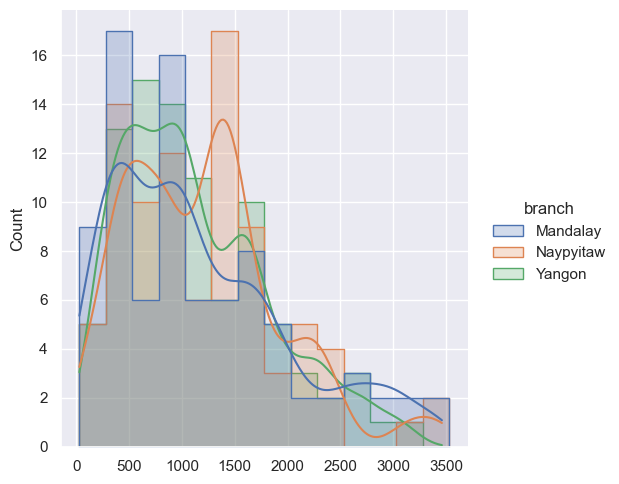

In [20]:
# daily sales distribution by branch
sns.displot(
    data= branch_daily_sales,
    binwidth= 250,
    element= 'step',
    kde= True,
    kde_kws= {'bw_adjust': 0.6}
);

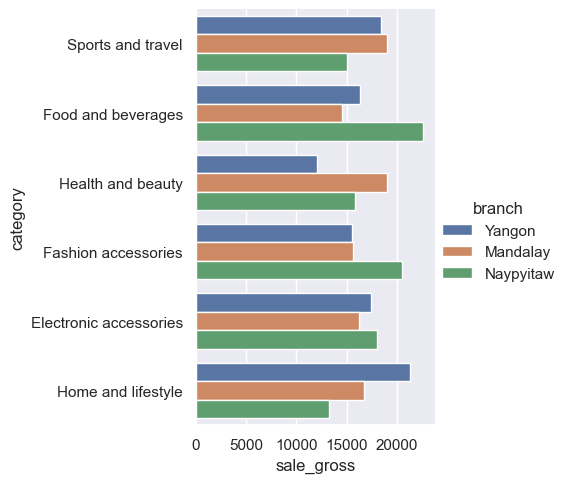

In [41]:
# category sales by branch
sns.catplot(
    data= supermarket_data,
    x= 'sale_gross',
    y= 'category',
    hue= 'branch',
    kind= 'bar',
    estimator= 'sum',
    errorbar= None
);

In [68]:
member_pct_by_branch = pd.DataFrame(
    supermarket_data[['branch', 'member']]
    .groupby('branch')
    .value_counts(normalize=True)
    .reset_index()
    .rename({0: 'proportion'}, axis=1)
)
member_pct_by_branch['proportion'] = member_pct_by_branch['proportion'].apply(
    lambda x: x * 100
)

In [71]:
member_pct_by_branch

,branch,member,proportion
0,Mandalay,0,50.301205
1,Mandalay,1,49.698795
2,Naypyitaw,1,51.524390
3,Naypyitaw,0,48.475610
4,Yangon,0,50.882353
5,Yangon,1,49.117647


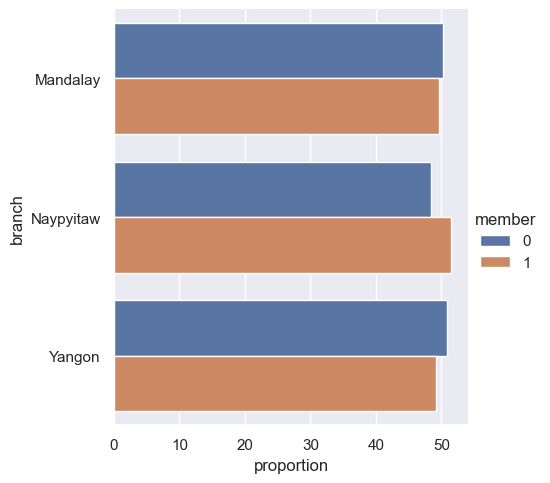

In [90]:
# member purchase ratios by branch
sns.catplot(
    data= member_pct_by_branch,
    y= 'branch',
    x= 'proportion',
    hue= 'member',
    kind= 'bar',
    orient= 'horizontal'
);

In [91]:
male_pct_by_branch = pd.DataFrame(
    supermarket_data[['branch', 'male']]
    .groupby('branch')
    .value_counts(normalize=True)
    .reset_index()
    .rename({0: 'proportion'}, axis=1)
)
male_pct_by_branch['proportion'] = male_pct_by_branch['proportion'].apply(
    lambda x: x * 100
)

In [92]:
male_pct_by_branch

,branch,male,proportion
0,Mandalay,1,51.204819
1,Mandalay,0,48.795181
2,Naypyitaw,0,54.268293
3,Naypyitaw,1,45.731707
4,Yangon,1,52.647059
5,Yangon,0,47.352941


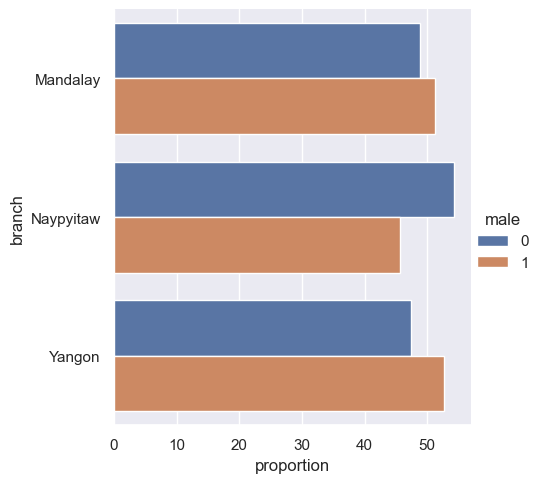

In [93]:
# member purchase ratios by branch
sns.catplot(
    data= male_pct_by_branch,
    y= 'branch',
    x= 'proportion',
    hue= 'male',
    kind= 'bar',
    orient= 'horizontal'
);